# Recommending songs using collaborative filtering method
> KNN and SVD models with hyperparameter tuning with the help of Surprise library. Using small subset of Million Songs Dataset.

- toc: true
- badges: true
- comments: true
- categories: [Surprise, KNN, SVD, Songs, MillionSongsDataset, Visualization, EDA]
- author: "<a href='https://github.com/ugis22/music_recommender'>Eugenia Inzaugarat</a>"
- image:

## Setup

In [54]:
!pip install -q fuzzywuzzy
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 238kB/s 


In [55]:
import numpy as np
import pandas as pd

from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz

from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

## Load dataset

In [2]:
songs_meta = pd.read_parquet('https://github.com/recohut/reco-data/raw/master/millionsongs/v1/items.parquet.gzip')
songs_meta.drop_duplicates(subset='song_id', inplace=True)
songs_meta.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [3]:
interactions = pd.read_parquet('https://github.com/recohut/reco-data/raw/master/millionsongs/v1/interactions.parquet.gzip')
interactions.drop_duplicates(subset=['song_id','user_id'], inplace=True, keep='last')
interactions.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


## EDA and cleaning

In [4]:
# add the listen count from interactions to the songs_meta
listen_counts = interactions.groupby('song_id', as_index=False)['listen_count'].sum()
songs_meta = pd.merge(songs_meta, listen_counts, on="song_id", how="left")
songs_meta.head()

,song_id,title,release,artist_name,year,listen_count
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003,NaN
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995,NaN
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006,NaN
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003,NaN
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0,NaN


In [27]:
songs_meta.shape

(999056, 6)

In [28]:
songs_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999056 entries, 0 to 999055
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   song_id       999056 non-null  object 
 1   title         999041 non-null  object 
 2   release       999051 non-null  object 
 3   artist_name   999056 non-null  object 
 4   year          999056 non-null  int64  
 5   listen_count  10000 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 53.4+ MB


In [30]:
songs_meta.describe()

,year,listen_count
count,999056.000000,10000.000000
mean,1029.688740,609.096900
std,998.762408,1401.268442
min,0.000000,71.000000
25%,0.000000,221.000000
50%,1969.000000,336.000000
75%,2002.000000,587.000000
max,2011.000000,54136.000000


In [31]:
songs_meta.describe(include=['O'])

,song_id,title,release,artist_name
count,999056,999041,999051,999056
unique,999056,702350,149211,72652
top,SOXBESB12AB017BC5F,Intro,Greatest Hits,Johnny Cash
freq,1,1510,2002,191


In [32]:
songs_meta.isnull().sum()

song_id              0
title               15
release              5
artist_name          0
year                 0
listen_count    989056
dtype: int64

In [5]:
# replacing NA titles with 'Unknown' string
songs_meta['title'].fillna("Unknown", inplace=True)

# replacing NA release with 'Unknown' string
songs_meta['release'].fillna("Unknown", inplace=True)

# replacing NA listen counts with 0 integer
songs_meta['listen_count'].fillna(0, inplace=True)

# rechecking the status of missing values
songs_meta.isnull().sum()

song_id         0
title           0
release         0
artist_name     0
year            0
listen_count    0
dtype: int64

### Most popular songs

In [35]:
ten_pop_songs = songs_meta.sort_values(['listen_count', 'title'], ascending = [0,1])
ten_pop_songs['percentage']  = round(ten_pop_songs['listen_count'].div(ten_pop_songs['listen_count'].sum())*100, 2)
ten_pop_songs = ten_pop_songs[:10]
ten_pop_songs

,song_id,title,release,artist_name,year,listen_count,percentage
448642,SOBONKR12A58A7A7E0,You're The One,If There Was A Way,Dwight Yoakam,1990,54136.0,0.89
111083,SOAUWYT12A81C206F1,Undo,Vespertine Live,Björk,2001,49253.0,0.81
864901,SOSXLTC12AF72A7F54,Revelry,Only By The Night,Kings Of Leon,2008,41418.0,0.68
618270,SOEGIYH12A6D4FC0E3,Horn Concerto No. 4 in E flat K495: II. Romanc...,Mozart - Eine kleine Nachtmusik,Barry Tuckwell/Academy of St Martin-in-the-Fie...,0,31153.0,0.51
807573,SOFRQTD12A81C233C0,Sehr kosmisch,Musik von Harmonia,Harmonia,0,31036.0,0.51
151684,SOAXGDH12A8C13F8A1,Dog Days Are Over (Radio Edit),Now That's What I Call Music! 75,Florence + The Machine,0,26663.0,0.44
862476,SONYKOW12AB01849C9,Secrets,Waking Up,OneRepublic,2009,22100.0,0.36
282220,SOPUCYA12A8C13A694,Canada,The End Is Here,Five Iron Frenzy,0,21019.0,0.35
419122,SOUFTBI12AB0183F65,Invalid,Fermi Paradox,Tub Ring,2002,19645.0,0.32
201840,SOVDSJC12A58A7A271,Ain't Misbehavin,Summertime,Sam Cooke,0,18309.0,0.30


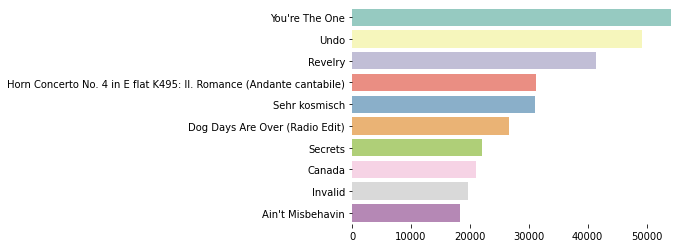

In [36]:
labels = ten_pop_songs['title'].tolist()
counts = ten_pop_songs['listen_count'].tolist()

plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

### Most popular artist

In [39]:
ten_pop_artists  = songs_meta.groupby(['artist_name'])['listen_count'].sum().reset_index().sort_values(['listen_count', 'artist_name'], ascending = [0,1])
ten_pop_artists = ten_pop_artists[:10]
ten_pop_artists

,artist_name,listen_count
12542,Coldplay,70138.0
34718,Kings Of Leon,68570.0
22312,Florence + The Machine,60066.0
18798,Dwight Yoakam,54136.0
7237,Björk,53814.0
62075,The Black Keys,52220.0
29137,Jack Johnson,44083.0
33129,Justin Bieber,41645.0
47228,OneRepublic,40981.0
67782,Train,39279.0


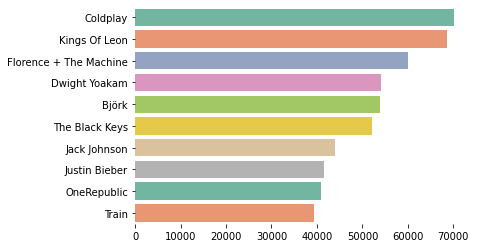

In [40]:
plt.figure()
labels = ten_pop_artists['artist_name'].tolist()
counts = ten_pop_artists['listen_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

### Listen count by user

What was the maximum time the same user listen to a same song?

In [48]:
interactions[interactions.listen_count==interactions.listen_count.max()]

,user_id,song_id,listen_count
1228366,d13609d62db6df876d3cc388225478618bb7b912,SOFCGSE12AF72A674F,2213


How many times on average the same user listen to a same song?

In [49]:
interactions.listen_count.mean()

3.0454845

We can also check the distribution of listen_count:

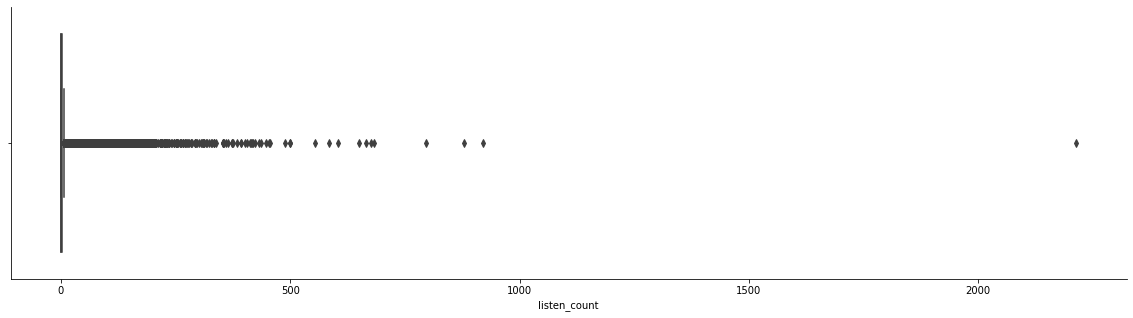

In [51]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='listen_count', data=interactions)
sns.despine()

How many songs does a user listen in average?

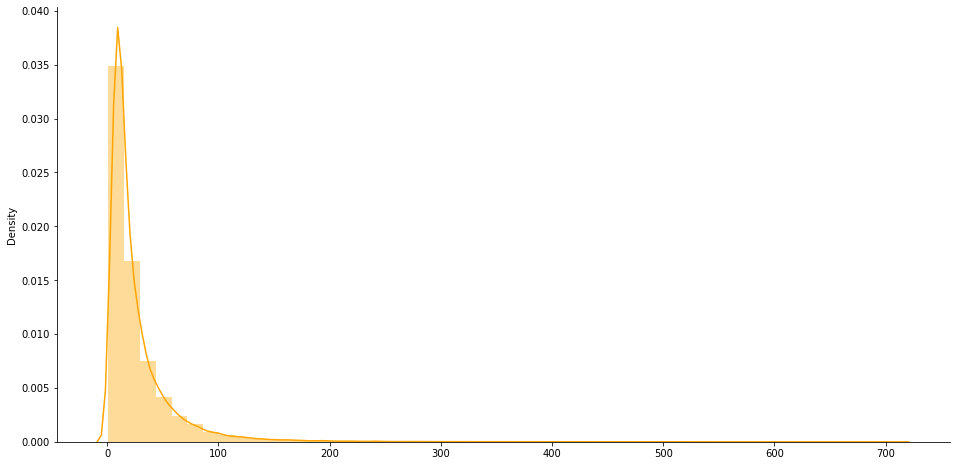

In [6]:
song_user = interactions.groupby('user_id')['song_id'].count()

plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

### Minimum interaction filter
Get users which have listened to at least 16 songs, and filter the dataset to keep only those users with more than 16 listened

In [7]:
filter_song_ids = song_user[song_user > 16].index.to_list()
filter_song_df = interactions[interactions['user_id'].isin(filter_song_ids)].reset_index(drop=True)

# convert the dataframe into a pivot table
df_songs_features = filter_song_df.pivot(index='song_id', columns='user_id', values='listen_count').fillna(0)

# obtain a sparse matrix
mat_songs_features = csr_matrix(df_songs_features.values)

In [8]:
df_songs_features.iloc[:10, :10].T

song_id,SOAAAGQ12A8C1420C8,SOAACPJ12A81C21360,SOAACSG12AB018DC80,SOAAEJI12AB0188AB5,SOAAFAC12A67ADF7EB,SOAAFYH12A8C13717A,SOAAJMQ12A6D4F7D17,SOAAKPM12A58A77210,SOAALWN12A6D4F7FDA,SOAAMOW12AB018149B
user_id,,,,,,,,,,
000e2c2a8c7870ff9121f212b35c8b3a20cc0e67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000ebc858861aca26bac9b49f650ed424cf882fc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000ef25cc955ad5841c915d269432eea41f4a1a5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0012bf75d43a724f62dc746d9e85ae0088a3a1d6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001322829b5dc3edc59bf78189617ddd8f23c82a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00185e316f07f0f00c325ca034be59c15b362401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0019740e3e8c24e223a6f88e3faa7c144ec5a014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001b005fe5e80d3cb45f320f5658fc8e2e72794e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001f22c638730aed5659034c447d3cf0e658898e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


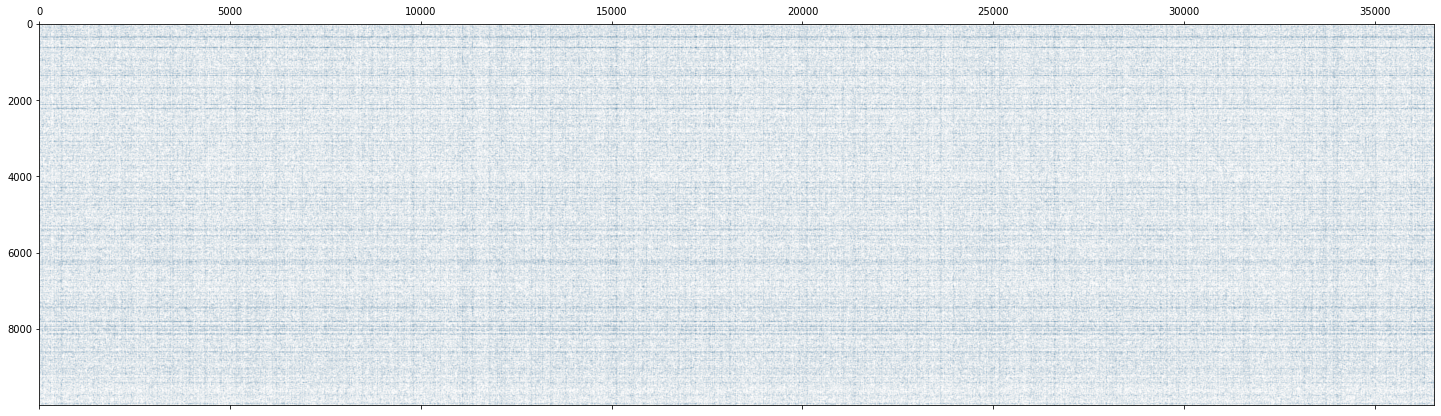

In [42]:
plt.figure(figsize=(25, 25))
plt.spy(mat_songs_features, markersize=0.005);

Because the system will output the id of the song, instead of the title, we'll make a function that maps those indices with the song title.

In [43]:
df_unique_songs = songs_meta.drop_duplicates(subset=['song_id']).reset_index(drop=True)[['song_id', 'title']]
decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('song_id').loc[df_songs_features.index].title))
}

## KNN Recommender

In [50]:
class KNNRecommender:
    def __init__(self, metric, algorithm, k, data, decode_id_song):
        self.metric = metric
        self.algorithm = algorithm
        self.k = k
        self.data = data
        self.decode_id_song = decode_id_song
        self.data = data
        self.model = self._recommender().fit(data)
    
    def make_recommendation(self, new_song, n_recommendations):
        recommended = self._recommend(new_song=new_song, n_recommendations=n_recommendations)
        return recommended 
    
    def _recommender(self):
        return NearestNeighbors(metric=self.metric, algorithm=self.algorithm, n_neighbors=self.k, n_jobs=-1)
    
    def _recommend(self, new_song, n_recommendations):
        # Get the id of the recommended songs
        recommendations = []
        recommendation_ids = self._get_recommendations(new_song=new_song, n_recommendations=n_recommendations)
        # return the name of the song using a mapping dictionary
        recommendations_map = self._map_indeces_to_song_title(recommendation_ids)
        # Translate this recommendations into the ranking of song titles recommended
        for i, (idx, dist) in enumerate(recommendation_ids):
            recommendations.append(recommendations_map[idx])
        return recommendations
                 
    def _get_recommendations(self, new_song, n_recommendations):
        # Get the id of the song according to the text
        recom_song_id = self._fuzzy_matching(song=new_song)
        # Start the recommendation process
        # Return the n neighbors for the song id
        distances, indices = self.model.kneighbors(self.data[recom_song_id], n_neighbors=n_recommendations+1)
        return sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    def _map_indeces_to_song_title(self, recommendation_ids):
        # get reverse mapper
        return {song_id: song_title for song_title, song_id in self.decode_id_song.items()}
    
    def _fuzzy_matching(self, song):
        match_tuple = []
        # get match
        for title, idx in self.decode_id_song.items():
            ratio = fuzz.ratio(title.lower(), song.lower())
            if ratio >= 60:
                match_tuple.append((title, idx, ratio))
        # sort
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print(f"The recommendation system could not find a match for {song}")
            return
        return match_tuple[0][1]

In [51]:
model = KNNRecommender(metric='cosine', algorithm='brute', k=20, data=mat_songs_features, decode_id_song=decode_id_song)

In [52]:
song = 'I believe in miracles'

new_recommendations = model.make_recommendation(new_song=song, n_recommendations=10)
print(f"The recommendations for {song} are:\n")
new_recommendations

The recommendations for I believe in miracles are:



['Nine Million Bicycles',
 'If You Were A Sailboat',
 'Shy Boy',
 'I Cried For You',
 "Spider's Web",
 'Piece By Piece',
 'On The Road Again',
 'Blues In The Night',
 'Blue Shoes',
 'Thank You Stars']

## Matrix factorization recommender

### Filtering

So we already know that it is a very sparse matrix. Dealing with such a sparse matrix, we'll take a lot of memory and resources. To make our life easier, we aalready selected users that have listened to at least 16 songs. Moreover, we are going to select only those songs which have been listened to by at least 200 users.

In [56]:
song_counts = interactions.groupby('song_id')['user_id'].count()
filter_song_count_ids = song_counts[song_counts > 200].index.to_list()
filter_song_df = interactions[interactions['song_id'].isin(filter_song_count_ids)].reset_index(drop=True)
filter_song_df.shape

(1159936, 3)

### Binning to convert implicit signals into target prediction

Instead of working with the implicit rating as it is, we'll apply the binning technique. We'll define 10 categories. The original data values which fall into the interval from 0 to 1, will be replaced by the representative rating of 1; if they fall into the interval 1 to 2, they will be replaced by 2; and so on and so forth. The last category will be assigned to original values ranging from 9 to 2213.

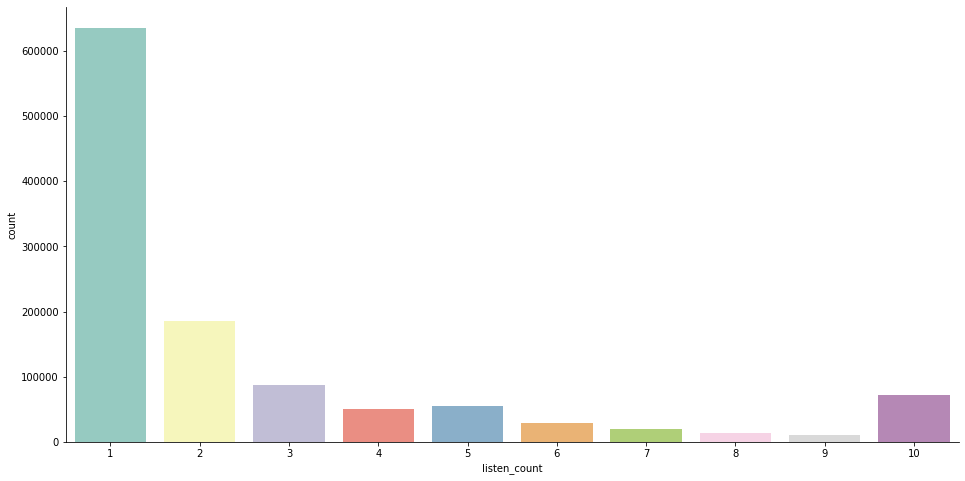

In [57]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214]
filter_song_df['listen_count'] = pd.cut(filter_song_df['listen_count'], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
listen_counts = pd.DataFrame(filter_song_df.groupby('listen_count').size(), columns=['count']).reset_index(drop=False)

plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set3', data=listen_counts)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

### Load data into Surprise format

To load a dataset from our DataFrame, we will use the load_from_df() method.

We will need to pass the following parameters:

- df: The dataframe containing the ratings. It must have three columns, corresponding to the user ids, the song ids, and the ratings.
- reader (Reader): A reader to read the file. Only the rating_scale field needs to be specified.

In [58]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(filter_song_df[['user_id', 'song_id', 'listen_count']], reader)
trainset, testset = train_test_split(data, test_size=.25)

### Training and hypertuning

In [61]:
param_grid = {'n_factors': [160], 
              'n_epochs': [100], 
              'lr_all': [0.001, 0.005],
              'reg_all': [0.08]}

grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=2, joblib_verbose=4, n_jobs=-2)

# find the best parameters for the model
grid_search_svd.fit(data)
find_algo = grid_search_svd.best_estimator['rmse']
print(grid_search_svd.best_score['rmse'])
print(grid_search_svd.best_params['rmse'])

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:  9.0min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed: 13.5min remaining:    0.0s


2.270527123504708
{'n_factors': 160, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.08}


[Parallel(n_jobs=-2)]: Done   4 out of   4 | elapsed: 18.0min finished


### Cross validation

In [ ]:
cross_validate(find_algo, data, measures=['RMSE'], cv=5, verbose=True)

### Evaluation

After finding the best parameters for the model, we create our final model, train it and find the error for the test set.

In [ ]:
final_algorithm = SVD(n_factors=160, n_epochs=100, lr_all=0.005, reg_all=0.1)
final_algorithm.fit(trainset)
test_predictions = final_algorithm.test(testset)
print(f"The RMSE is {accuracy.rmse(test_predictions, verbose=True)}")